In [1]:
import os
import h5py

import pandas
import numpy as np
import astropy
from matplotlib import pyplot as plt
from matplotlib import colors

from illustris_python.snapshot import loadHalo
%matplotlib inline
%config InlineBackend.figure_format = 'png'

Choose the `simulation.hdf5` file



In [2]:
dir = "../TNG100-3-Dark/"
file = "simulation.hdf5"
path = os.path.join(dir, file)

Read the `simulation.hdf5` file

In [3]:
data = h5py.File(path)

<ipython-input-3-e83e8f9293ba>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data = h5py.File(path)


Helper functions

In [4]:
def comoving_to_physical(comoving, h=data['Header'].attrs['HubbleParam']):
    return comoving/h/1000

def density_to_physical(
        density, bins,
        dm_mass=data['Header'].attrs['MassTable'][1],
):
    binsize = 1/bins**2  # todo
    return density * dm_mass / binsize

Select the desired snapshot (z=0)

In [5]:
snapshot = data['Groups']['99']

In [6]:
data['Groups']['99']['Header']

<HDF5 group "/Groups/99/Header" (0 members)>

Plot all the subhaloes with different projections


In [7]:
size = (1,3)
n = size[0]*size[1]
# zmin = np.min(snapshot['Group']['GroupPos'][:,2])
# zmax = np.max(snapshot['Group']['GroupPos'][:,2])
xyzdict={0:"X, Mpc", 1:"Y, Mpc", 2:"Z, Mpc"}
# for i in range(1, n+1):
#     axes = plt.subplot(*size, i, aspect='equal')
#     zbottom = zmin + (zmax-zmin)*(i-1)
#     ztop = zmin + (zmax-zmin)*i
#     print(i,zbottom, ztop)
#
#     # group_is_at_this_z = (
#     #     (snapshot['Group']['GroupPos'][:,2] < ztop) &
#     #     (snapshot['Group']['GroupPos'][:,2] > zbottom)
#     # )
#
#     # print(group_is_at_this_z)
#
#     axes.hist2d(
#         snapshot['Group']['GroupPos'][:,(i)%3],
#         snapshot['Group']['GroupPos'][:,(i+1)%3],
#         bins=100
#     )
#     # axes.scatter(
#     #         snapshot['Group']['GroupPos'][:,(i)%3],
#     #         snapshot['Group']['GroupPos'][:,(i+1)%3],
#     #         s=0.001
#     #     )
#     axes.set_xlabel(xyzdict[i%3])
#     axes.set_ylabel(xyzdict[(i+1)%3])

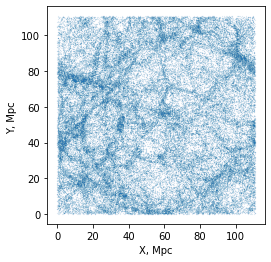

In [8]:
i=3
axes = plt.subplot(aspect='equal')
axes.scatter(
    comoving_to_physical(snapshot['Group']['GroupPos'][:,(i)%3]),
    comoving_to_physical(snapshot['Group']['GroupPos'][:,(i+1)%3]),
    s=0.01, alpha=0.5

)
axes.set_xlabel(f"{xyzdict[i%3]}")
axes.set_ylabel(f"{xyzdict[(i+1)%3]} ")
plt.savefig("haloes_coords.png")


Haloes with masses

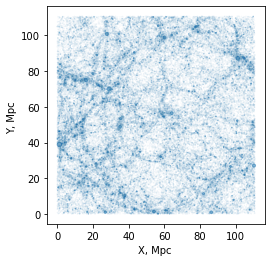

In [9]:
axes = plt.subplot(aspect='equal')
maxmass = np.max(snapshot['Group']['GroupMass'])
axes.scatter(
    comoving_to_physical(snapshot['Group']['GroupPos'][:,(i)%3]),
    comoving_to_physical(snapshot['Group']['GroupPos'][:,(i+1)%3]),
    s=snapshot['Group']['GroupMass']/maxmass*20, alpha=0.5
)
axes.set_xlabel(f"{xyzdict[i%3]} ")
axes.set_ylabel(f"{xyzdict[(i+1)%3]} ")
plt.savefig("haloes_mass.png")


Dark matter, every 1000th particles (this was slow!)

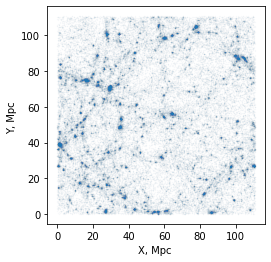

In [10]:
snapshot = data['Snapshots']['99']
snapshot['PartType1'].keys()

axes = plt.subplot(aspect='equal')
axes.scatter(
    comoving_to_physical(snapshot['PartType1']['Coordinates'][::1000,0]),
    comoving_to_physical(snapshot['PartType1']['Coordinates'][::1000,1]),
    s=0.1, alpha=0.05
)
axes.set_xlabel(f"{xyzdict[0]} ")
axes.set_ylabel(f"{xyzdict[1]} ")
plt.savefig("dm_particles.png")

Dark matter, all histogram

In [11]:
dict(data['Header'].attrs.items())

{'BoxSize': 75000.0,
 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699',
 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200',
 'HubbleParam': 0.6774,
 'MassTable': array([0.        , 0.03839801, 0.        , 0.        , 0.        ,
        0.        ]),
 'Omega0': 0.3089,
 'OmegaBaryon': 0.0486,
 'OmegaLambda': 0.6911,
 'UnitLength_in_cm': 3.085678e+21,
 'UnitMass_in_g': 1.989e+43,
 'UnitVelocity_in_cm_per_s': 100000.0}

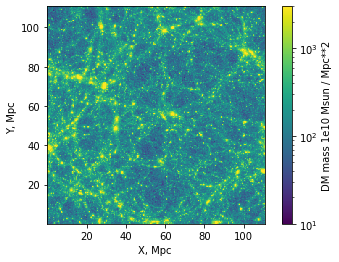

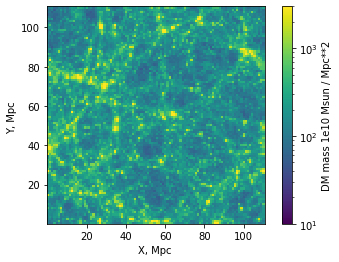

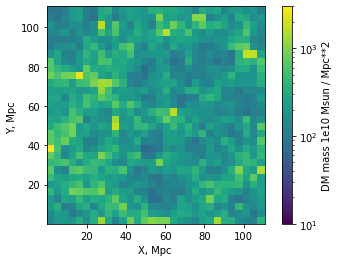

In [12]:
norm=colors.LogNorm(10, 3000)
particle_sampling = 10
for bins in [300,100,30]:
    axes = plt.subplot(aspect='equal')
    coords = comoving_to_physical(snapshot['PartType1']['Coordinates'][::particle_sampling,:])
    xbin = (np.max(coords[:,0]) - np.min(coords[:,0]))/bins
    ybin = (np.max(coords[:,1]) - np.min(coords[:,1]))/bins
    _,_,_, histdata = axes.hist2d(
        coords[:,0],
        coords[:,1],
        bins=bins,
        norm=norm,
        weights=len(coords[:,0]) * [
            data['Header'].attrs['MassTable'][1] * particle_sampling / xbin / ybin
        ]
    )
    axes.set_xlabel(f"{xyzdict[0]} ")
    axes.set_ylabel(f"{xyzdict[1]} ")
    plt.colorbar(histdata, label="DM mass 1e10 Msun / Mpc**2")
    plt.savefig(f"dm_hist_{bins}.png")
    plt.show()

One halo


Group 1 mass:  {34870.42}
Group 20 mass:  {7500.2446}
Group 101 mass:  {1876.1267}
Group 1000 mass:  {186.92151}


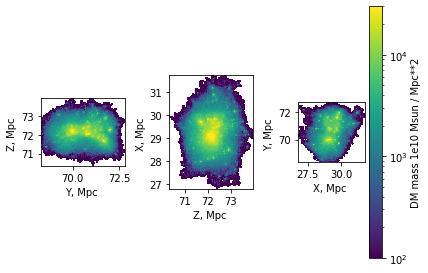

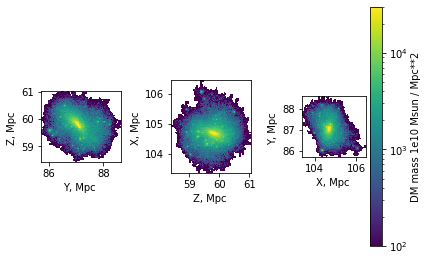

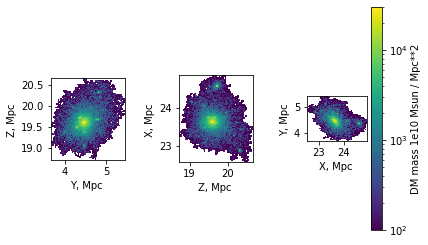

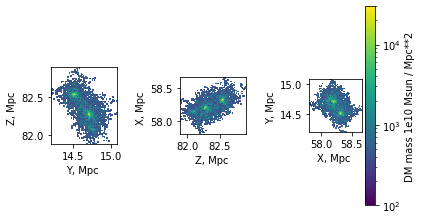

In [13]:
norm=colors.LogNorm(100, 30000)
particle_sampling = 1
snapshot_id = 99
groups = [1, 20, 101, 1000]
for ig, group in enumerate(groups):
    print(f"Group {group} mass: ",
          {data['Groups'][f'{snapshot_id}']['Group']['GroupMass'][group]})
    coords = comoving_to_physical(loadHalo(os.path.join(dir, "output"),snapshot_id, group, 1, 'Coordinates'))[::particle_sampling,:]
    for i in range(1, 4):
        bins=100
        xbin = (np.max(coords[:,i%3]) - np.min(coords[:,i%3]))/bins
        ybin = (np.max(coords[:,(i+1)%3]) - np.min(coords[:,(i+1)%3]))/bins
        axes = plt.subplot(1, 3, i, aspect='equal')
        _,_,_, histdata = axes.hist2d(
            coords[:,i%3],
            coords[:,(i+1)%3],
            bins=bins,
            norm=norm,
            weights=len(coords[:,0]) * [
                        data['Header'].attrs['MassTable'][1] * particle_sampling / xbin / ybin
            ]
        )
        axes.set_xlabel(f"{xyzdict[(i)%3]} ")
        axes.set_ylabel(f"{xyzdict[(i+1)%3]} ")
    plt.colorbar(histdata, label="DM mass 1e10 Msun / Mpc**2", ax=axes)
    plt.tight_layout()
    plt.savefig(f"dm_{group}.png")
    plt.show()

In [14]:
xyzdict

{0: 'X, Mpc', 1: 'Y, Mpc', 2: 'Z, Mpc'}